In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import interp1d as interp1d
from scipy import stats
#import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import psycopg2
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
from joblib import Parallel, delayed
import gc
from matplotlib.pyplot import cm
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import optimize
import gc

## Functions

In [3]:
def delayed_moving_ave(d,return_simple=True):
    
    #Initialize output dictionary
    sos_dma={}
    #Rolling means Forward (SOS) and Backwards (EOS)
    d.columns = ['d_time','ndvi']
    ts = d.sort_values(by='d_time')[['d_time','ndvi']].set_index('d_time')
    ts['ndvi_rolling'] = ts.rolling(window=9*14,min_periods=9*4,center=False).mean()
    ts['ndvi_rolling_inv'] = ts.sort_values(by='d_time',ascending=False).rolling(window=9*6,min_periods=9*4,center=False).mean().ndvi.values
    
    #Smooth the TS
    ts['doy']=ts.index.dayofyear
    ts['ndvi_smoothed'] = savgol_filter(ts.ndvi.values,9*6+1, 2)
    
    #AVG Range in NDVI for years
    ndvi_range = (ts.groupby(by=ts.index.year).max().ndvi_smoothed-ts.groupby(by=ts.index.year).min().ndvi_smoothed).mean()
    
    #Loop over all years
    for y in ts.index.year.unique():
        
        #SOS Calcs
        ts_y = ts[ts.index.year==y].copy()#ts_smn = ts[ts.index.year==y].merge(ts[ts.index.year==y],left_index=True,right_index=True,suffixes=('_rolling','_orig'))
        ts_y['ndvi_diff'] = ts_y.ndvi_smoothed-ts_y.ndvi_rolling
        ts_y['cross'] = np.sign(ts_y.ndvi_diff.shift(1))!=np.sign(ts_y.ndvi_diff)
        ts_y['cross_idx'] = np.cumsum(ts_y.cross)-1
        try:
            s = ts_y.reset_index().d_time.iloc[np.where(ts_y.cross_idx == 1)[0].min()]
        except:
            s = np.nan
        
        #EOS Calcs from June thru Feb
        ts_y_inv =  ts[(ts.index>pd.to_datetime(y*1000+180,format='%Y%j')) & (ts.index<pd.to_datetime((y+1)*1000+60,format='%Y%j'))].sort_values(by='d_time',ascending=False).copy()
        ts_y_inv['ndvi_diff'] = ts_y_inv.ndvi_smoothed-ts_y_inv.ndvi_rolling_inv
        ts_y_inv['cross'] = np.sign(ts_y_inv.ndvi_diff.shift(1))!=np.sign(ts_y_inv.ndvi_diff)
        ts_y_inv['cross_idx'] = np.cumsum(ts_y_inv.cross)-1
        try:
            e = ts_y_inv.reset_index().d_time.iloc[np.where(ts_y_inv.cross_idx == 1)[0].min()]
        except:
            e=np.nan

        #Define date of Max value
        max_doy = ts_y.reset_index().d_time.iloc[np.where(ts_y.ndvi_smoothed.max()==ts_y.ndvi_smoothed)[0].max()]
        
        
        #Check if DMA is between 5% and 20% of yearly amplitude - if not adjust
        ts_th = ts[(ts.index >= pd.to_datetime((y*1000)+1,format='%Y%j')) & (ts.index <= max_doy)].copy()
        ts_inv_th = ts[(ts.index >= max_doy) & (ts.index <= pd.to_datetime(((y+1)*1000)+60,format='%Y%j'))].copy()
        
        #ndvi and date of lower threshold for EOS
        ndvi_thresh_low_inv = (ndvi_range*.075)+ts_inv_th.ndvi_smoothed.min()
        #ndvi_thresh_low_inv = ((ts_inv_th.ndvi_smoothed.max()-ts_inv_th.ndvi_smoothed.min())*.05)+ts_inv_th.ndvi_smoothed.min()
        ts_y_inv['ndvi_diff_thresh_low'] = ts_y_inv.ndvi_smoothed-ndvi_thresh_low_inv
        ts_y_inv['cross_thresh_low'] = np.sign(ts_y_inv.ndvi_diff_thresh_low.shift(1))!=np.sign(ts_y_inv.ndvi_diff_thresh_low)
        ts_y_inv.loc[pd.isnull(ts_y_inv.ndvi_diff_thresh_low),'cross_thresh_low']=0
        ts_y_inv['cross_idx_thresh_low'] = np.cumsum(ts_y_inv.cross_thresh_low)-1
        ndvi_thresh_low_date_inv = ts_y_inv[(ts_y_inv.cross_idx_thresh_low == 1)&(ts_y_inv.index>max_doy)&pd.notnull(ts_y_inv.ndvi_smoothed)].reset_index().d_time.max()
        
        #ndvi and date of lower threshold for SOS
        ndvi_thresh_low = (ndvi_range*.075)+ts_th.ndvi_smoothed.min()
        #ndvi_thresh_low = ((ts_th.ndvi_smoothed.max()-ts_th.ndvi_smoothed.min())*.05)+ts_th.ndvi_smoothed.min()
        ts_y['ndvi_diff_thresh_low'] = ts_y.ndvi_smoothed-ndvi_thresh_low
        ts_y['cross_thresh_low'] = np.sign(ts_y.ndvi_diff_thresh_low.shift(1))!=np.sign(ts_y.ndvi_diff_thresh_low)
        ts_y.loc[pd.isnull(ts_y.ndvi_diff_thresh_low),'cross_thresh_low']=0
        #ts_y.loc[pd.isnull(ts_y.cross_idx_thresh_low),'cross_idx_thresh_low']=0
        ts_y['cross_idx_thresh_low'] = np.cumsum(ts_y.cross_thresh_low)-1
        ndvi_thresh_low_date = ts_y[(ts_y.cross_idx_thresh_low == 1)&(ts_y.index<max_doy)&pd.notnull(ts_y.ndvi_smoothed)].reset_index().d_time.min()
        
        #ndvi and date of upper threshold for EOS
        ndvi_thresh_high_inv = (ndvi_range*.2)+ts_inv_th.ndvi_smoothed.min()
        #ndvi_thresh_high_inv = ((ts_inv_th.ndvi_smoothed.max()-ts_inv_th.ndvi_smoothed.min())*.2)+ts_inv_th.ndvi_smoothed.min()
        ts_y_inv['ndvi_diff_thresh_high'] = ts_y_inv.ndvi_smoothed-ndvi_thresh_high_inv
        ts_y_inv['cross_thresh_high'] = np.sign(ts_y_inv.ndvi_diff_thresh_high.shift(1))!=np.sign(ts_y_inv.ndvi_diff_thresh_high)
        ts_y_inv.loc[pd.isnull(ts_y_inv.ndvi_diff_thresh_high),'cross_thresh_high']=0
        ts_y_inv['cross_idx_thresh_high'] = np.cumsum(ts_y_inv.cross_thresh_high)-1
        ndvi_thresh_high_date_inv = ts_y_inv[(ts_y_inv.cross_idx_thresh_high == 1)&(ts_y_inv.index>max_doy)&pd.notnull(ts_y_inv.ndvi_smoothed)].reset_index().d_time.max()
        
        #ndvi and date of upper threshold for SOS
        ndvi_thresh_high = (ndvi_range*.2)+ts_th.ndvi_smoothed.min()
        #ndvi_thresh_high = ((ts_th.ndvi_smoothed.max()-ts_th.ndvi_smoothed.min())*.2)+ts_th.ndvi_smoothed.min()
        ts_y['ndvi_diff_thresh_high'] = ts_y.ndvi_smoothed-ndvi_thresh_high
        ts_y['cross_thresh_high'] = np.sign(ts_y.ndvi_diff_thresh_high.shift(1))!=np.sign(ts_y.ndvi_diff_thresh_high)
        ts_y.loc[pd.isnull(ts_y.ndvi_diff_thresh_high),'cross_thresh_high']=0
        ts_y['cross_idx_thresh_high'] = np.cumsum(ts_y.cross_thresh_high)-1
        ndvi_thresh_high_date = ts_y[(ts_y.cross_idx_thresh_high == 1)&(ts_y.index>max_doy)&pd.notnull(ts_y.ndvi_smoothed)].reset_index().d_time.min()

        
        #Values at 15% range if no solution for dma
        #SOS
        ndvi_thresh_s = (ndvi_range*.15)+ts_th.ndvi_smoothed.min()
        ts_y['ndvi_diff_thresh_s'] = ts_y.ndvi_smoothed-ndvi_thresh_s
        ts_y['cross_thresh_s'] = np.sign(ts_y.ndvi_diff_thresh_s.shift(1))!=np.sign(ts_y.ndvi_diff_thresh_s)
        ts_y.loc[pd.isnull(ts_y.ndvi_diff_thresh_s),'cross_thresh_s']=0
        ts_y['cross_idx_thresh_s'] = np.cumsum(ts_y.cross_thresh_s)-1
        ndvi_thresh_s_date = ts_y[(ts_y.cross_idx_thresh_s == 1)&(ts_y.index<max_doy)&pd.notnull(ts_y.ndvi_smoothed)].reset_index().d_time.min()
        
        #EOS
        ndvi_thresh_e_inv = (ndvi_range*.15)+ts_inv_th.ndvi_smoothed.min()
        ts_y_inv['ndvi_diff_thresh_e'] = ts_y_inv.ndvi_smoothed-ndvi_thresh_e_inv
        ts_y_inv['cross_thresh_e'] = np.sign(ts_y_inv.ndvi_diff_thresh_e.shift(1))!=np.sign(ts_y_inv.ndvi_diff_thresh_e)
        ts_y_inv.loc[pd.isnull(ts_y_inv.ndvi_diff_thresh_e),'cross_thresh_e']=0
        ts_y_inv['cross_idx_thresh_e'] = np.cumsum(ts_y_inv.cross_thresh_e)-1
        ndvi_thresh_e_date_inv = ts_y_inv[(ts_y_inv.cross_idx_thresh_e == 1)&(ts_y_inv.index>max_doy)&pd.notnull(ts_y_inv.ndvi_smoothed)].reset_index().d_time.max()
        
        
        if pd.isnull(s):
            s = ndvi_thresh_s_date
        else:
            if s < ndvi_thresh_low_date:
            #if ts_y.ndvi_smoothed.iloc[np.where(ts_y.cross_idx == 1)[0].min()] < ndvi_thresh_low and ts_y.reset_index().d_time.iloc[np.where(ts_y.cross_idx == 1)[0].min()] < ndvi_thresh_low_date:
                try:
                    s2 = ts_y[(ts_y.ndvi_smoothed>=ndvi_thresh_low)&(ts_y.index<max_doy) & (ts_y.index>=ndvi_thresh_low_date) & (ts_y.index<=ndvi_thresh_high_date)].reset_index().d_time.min()
                    #s2=ts_y.reset_index().d_time.iloc[np.where((ts_y.ndvi_smoothed>ndvi_thresh_low)&(ts_y<max_doy).ndvi_smoothed)[0].min()]
#                     print('Redoing SOS for year '+str(y))
                except:
#                     print('Failed SOS')
                    s2=np.nan
                    None
            elif s > ndvi_thresh_high_date:
            #elif ts_y.ndvi_smoothed.iloc[np.where(ts_y.cross_idx == 1)[0].min()] > ndvi_thresh_high and ts_y.reset_index().d_time.iloc[np.where(ts_y.cross_idx == 1)[0].min()] > ndvi_thresh_high_date:
                try:
                    s2 = ts_y[(ts_y.ndvi_smoothed>=ndvi_thresh_high)&(ts_y.index<max_doy) & (ts_y.index>=ndvi_thresh_low_date) & (ts_y.index<=ndvi_thresh_high_date)].reset_index().d_time.max()
#                     print('Redoing SOS for year '+str(y))
                except:
#                     print('Failed SOS')
                    s2=np.nan
                    None
            else:
                s2=np.nan
        if pd.isnull(e):
            e = ndvi_thresh_e_date_inv
        else:
            if e > ndvi_thresh_low_date_inv:
            #if ts_y_inv.ndvi_smoothed.iloc[np.where(ts_y_inv.cross_idx == 1)[0].min()] < ndvi_thresh_low_inv and ts_y_inv.reset_index().d_time.iloc[np.where(ts_y_inv.cross_idx == 1)[0].min()] > ndvi_thresh_low_date_inv:
                try:
                    e2=ts_y_inv[(ts_y_inv.ndvi_smoothed>=ndvi_thresh_low_inv)&(ts_y_inv.index>=max_doy) & (ts_y_inv.index<=ndvi_thresh_low_date_inv) & (ts_y_inv.index>=ndvi_thresh_high_date_inv)].reset_index().d_time.max()
#                     print('Redoing EOS for year '+str(y))
                except:
#                     print('Failed EOS')
                    e2=np.nan
                    None

            elif e < ndvi_thresh_high_date_inv:
            #elif ts_y_inv.ndvi_smoothed.iloc[np.where(ts_y_inv.cross_idx == 1)[0].min()] > ndvi_thresh_high_inv and ts_y_inv.reset_index().d_time.iloc[np.where(ts_y_inv.cross_idx == 1)[0].max()] < ndvi_thresh_high_date_inv:
                try:
                    e2=ts_y_inv[(ts_y_inv.ndvi_smoothed<ndvi_thresh_high_inv)&(ts_y_inv.index>=max_doy) & (ts_y_inv.index<=ndvi_thresh_low_date_inv) & (ts_y_inv.index>=ndvi_thresh_high_date_inv)].reset_index().d_time.min()
#                     print('Redoing EOS for year '+str(y))
                except:
#                     print('Failed EOS')
                    e2=np.nan
                    None
            else:
                e2=np.nan
            
    ### Collect the data in dictionary
        if return_simple:
            if pd.notnull(e2):
                e_final=e2
            else:
                e_final=e
            if pd.notnull(s2):
                s_final=s2
            else:
                s_final=s
            sos_dma[y]={'sos':s,'eos':e}
        else:
            sos_dma[y]={'sos':[s,s2],'eos':[e,e2],'thresh_l':ndvi_thresh_low,'thresh_h':ndvi_thresh_high,'thresh_l_inv':ndvi_thresh_low_inv,'thresh_h_inv':ndvi_thresh_high_inv}
    if return_simple==False:
        sos_dma['all']={'eos_ts':ts['ndvi_rolling_inv'],'sos_ts':ts['ndvi_rolling'],'sm_ts':ts['ndvi_smoothed']}
    return(sos_dma)

In [208]:
def int_ndvi(ts_all,var,p):
    df_int = pd.DataFrame()
    ts_all = ts_all.rename(columns={'pasture_'+str.upper(var):var})
    ndvi_min_ts = ts_all.reset_index()[ts_all.reset_index().m_date.dt.dayofyear<=30][var]
    if var == 'ndvi':
        ndvi_min =ndvi_min_ts[ndvi_min_ts<1900.].median()/10000.
    elif var == 'apar':
        ndvi_min =ndvi_min_ts[ndvi_min_ts<.2].median()
    else:
        print('ERROR ERROR Wrong Var')
    
    
    im = plt.hist(ts_all.reset_index()[ts_all.reset_index().m_date.dt.dayofyear<=30][var])[1]
    
    if var=='ndvi':
        plt.axvline(x=1900., color='k', linestyle='--')
        plt.axvline(x=ndvi_min*10000., color='r', linestyle='--')
    if var=='apar':
        plt.axvline(x=.2, color='k', linestyle='--')
        plt.axvline(x=ndvi_min, color='r', linestyle='--')
    plt.savefig(var+'_'+p+'_MODIS_minvals_hist.png')
    plt.clf()
    
    i=-1
    for y in ts_all.index.year.unique():

        i=i+1
        #if ts_all[ts_all.index.year==y].EOS.dt.year.unique()[0] != y:
        #    ts = ts_all[(ts_all.index>=pd.to_datetime(y*1000+1,format='%Y%j')) & (ts_all.index<=ts_all[ts_all.index.year==y].EOS.unique()[0])].copy()
        #else:
        #    ts = ts_all[ts_all.index.year==y].copy()
        
        #### integration Period (Inclusive) ####
        sos = pd.to_datetime('3/1/'+str(y))
        eos = pd.to_datetime('1/1/'+str(y+1))
        
        ts = ts_all[(ts_all.index>=sos) & (ts_all.index<=eos)].copy()

        ts.reset_index(inplace=True)
        ts = ts.sort_values(by='m_date')
        ts = ts[pd.notnull(ts[var])].copy()
        
        if var == 'ndvi':
            ts[var]=ts[var]/10000.
        #sos = ts[ts.m_date.dt.year==y].SOS.dt.dayofyear.unique().astype(int)[0]
        #eos= ts[ts.m_date.dt.year==y].EOS.dt.dayofyear.unique().astype(int)[0]

        #s_date_diff = 0
        #if sos < s_date:
        #    ts['SOS']=ts.m_date.min()
        #    s_date_diff = s_date - sos
        #    sos=s_date
        #num_days = (ts[ts.m_date.dt.year==y].EOS.unique() - ts[ts.m_date.dt.year==y].SOS.unique()).astype('timedelta64[D]')[0].astype(int)#-s_date_diff
        #num_days = eos.dayofyear-sos.dayofyear
        #ndvi_min = ts[ts.m_date.dt.dayofyear<=90][var].mean()
        ts[var+'_rel'] = ts[var]-ndvi_min
        
        ts.loc[ts[var+'_rel']<0,var+'_rel']=0
        #tot_days = np.arange(num_days+1,dtype=float)+1
        if np.max(np.diff(ts.m_date.dt.dayofyear.values))>1:
            error = 1+'o'
        x_vals = ts.m_date.dt.dayofyear.values
        x_vals[-1]=x_vals[-2]+1
        ndvi_i_vals = integrate.cumtrapz(x=x_vals,y=ts[(ts.m_date>=sos)&(ts.m_date<=eos)][var+'_rel'].values)

        #if ts[ts.m_date.dt.year==y].EOS.dt.year.unique() != y:
        #    end_days = 0+1
        #    tot_days = np.concatenate([np.arange(ts.m_date.dt.dayofyear.max()-s_date+1,dtype=int)+s_date,np.arange(eos)+1])
        #else:
        #    end_days = ts.m_date.dt.dayofyear.max()-eos+1
        #    tot_days = np.arange(ts.m_date.dt.dayofyear.max()-s_date+1,dtype=int)+s_date
        #df_t = pd.DataFrame({'doy':tot_days,'ndvi_i':np.concatenate((np.zeros(sos.dayofyear-s_date),ndvi_i_vals,np.ones(end_days)*ndvi_i_vals[-1]))})

        df_t = pd.DataFrame({'doy':ts.m_date.dt.dayofyear.values[0:-1],'ndvi_i':ndvi_i_vals})
        df_t.rename(columns={'ndvi_i':var+'_i'})
        df_t['m_date'] = ts[pd.notnull(ts[var])].m_date.values[0:-1]
        df_int = df_int.append(df_t)
    
    return(df_int.groupby(by=['m_date','doy']).sum())    

## Query Data

In [5]:
parallelize = True
df_all = {}
df = pd.DataFrame()
#conn  = psycopg2.connect("host='localhost' dbname='cper'")
savgo  = False
raw = True
all_dat = False

analysis_yrs=[2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
#analysis_yrs=[2014]
args = []
for e in analysis_yrs:
    if all_dat:
        args.append(['mod'+str(e)+'doy_ndvi_cper_04qa','doy'])
    if savgo:
        args.append(['mod'+str(e)+'doy_ndvi_savgo_cper_04qa','savgo'])
    if raw:
        args.append(['mod'+str(e)+'doy_ndvi_raw_cper_04qa','raw'])
def qry_dat(args):
    #rad = '100'
    #conn = psycopg2.connect("host='localhost' dbname='cper'")
    yr = args[0][3:7]
    rs_table = args[0]
    typ = args[1]
    conn  = psycopg2.connect("host='localhost' dbname='cper' port='5434' password='Climber9'")
    sql = '''SELECT filename,doy,val as ndvi,past_name_,x,y,yr,ST_AREA(ST_INTERSECTION(past_geom,geom))/ST_Area(geom) as pix_overlap,ST_AREA(ST_INTERSECTION(past_geom,geom))/ST_Area(past_geom) as perc_pasture FROM (SELECT filename, band as doy,(ST_PixelAsPolygons(ST_Band(rast,band))).*,'''+yr+''' as yr FROM '''+rs_table+''', generate_series(1,365) As band)R,(SELECT ST_Transform(wkb_geometry,96842) as past_geom,past_name_ FROM cper_pastures_2017) as p WHERE ST_Intersects(past_geom,geom);'''
    #OLDER Query
    #sql = '''SELECT band as doy,b.past_name_, (ST_SUMMARYStats(ST_CLIP(ST_SETVALUE(m.rast,band,ST_TRANSFORM(e.geom,96842),(ST_BANDMETADATA(m.rast,band)).nodatavalue),ST_TRANSFORM(b.geom,96842)),band)).* as rast FROM '''+rs_table+''' as m,ltgi_exclude as e,generate_series(1,365) As band ,pasture_bound2016 as b WHERE past_name_ in ('15E','23W','23E') ORDER BY past_name_,doy;'''
    df = pd.read_sql(sql,conn)
    conn.close()
    return({args[0]:df})

if parallelize:
    df_all = Parallel(n_jobs=8, verbose=0, backend="multiprocessing")(map(delayed(qry_dat), args))
    for i in range(len(df_all)):
        k = list(df_all[i].keys())[0]
        df = df.append(df_all[i][k])
else:
    for a in args:
        print('Querying Year '+a[3:7])
        d = qry_dat(a)
        df = df.append(d[a])
df = df[df.pix_overlap>.01]

## Export NDVI observations

In [6]:
df_raw = pd.DataFrame()
df_interp = pd.DataFrame()
for p in df.past_name_.unique():
    df_temp = df[df.past_name_== p].copy()
    pix_dict = {i+1:v for i,v in enumerate(df_temp[['x','y']].groupby(by=['x','y']).count().reset_index().values)}
    df_temp['pix_id'] = -9
    for i in pix_dict:
        x = pix_dict[i][0]
        y = pix_dict[i][1]
        df_temp.loc[(df_temp.x==x) & (df_temp.y==y),'pix_id']=int(i)
    df_raw = df_raw.append(df_temp.pivot_table(index=['yr','doy','filename','past_name_'],columns='pix_id',values=['ndvi','pix_overlap','perc_pasture']).groupby(axis=1,level=['pix_id',0]).mean())
    del(df_temp)
    gc.collect()
df_raw.sort_values(by=['past_name_','yr','doy']).to_excel('CPER_MODIS_Pasture_Observed_NDVI_V2.xlsx')

## Compute Just NDVI

In [ ]:
# #df_interp = pd.DataFrame()
# for p in df_raw.reset_index().past_name_.unique()[0:1]:
#     print(p)
#     df_temp2 = df_raw.reset_index()[df_raw.reset_index().past_name_== p].copy()
#     df_temp2.dropna(axis=1,how='all',inplace=True)
#     df_temp2 = df_temp2.reset_index()
#     df_temp2['m_date'] = pd.to_datetime(df_temp2.yr*1000+df_temp2.doy,format='%Y%j')
#     df_temp2.sort_values(by='m_date',inplace=True)
#     df_temp2.set_index('m_date',inplace=True)
#     g_columns=[]
#     for x in df_temp2.columns.levels[0]:
#         if df_temp2[x].size > 0:
#             g_columns.append(x)
# #     df_temp2=df_temp2[g_columns].copy()
    
    
#     df_interp1 = pd.DataFrame()
#     df_interp1 = df_temp2.resample('D').interpolate()
    
    
#     df_interp1['past_name_']=p
    


#     for x in g_columns:
#         if type(x)==int:
#             df_interp1.loc[:,(x,'eff_ndvi')] = df_interp1[x].ndvi*df_interp1[x].perc_pasture
    
#     df_interp1 = df_interp1.reset_index().drop(columns=['filename','index']).set_index(['m_date','yr','doy','past_name_']).groupby(axis=1,level=['pix_id',1]).mean()
    
#     df_past_ndvi_temp = pd.DataFrame(df_interp1.swaplevel(axis=1).eff_ndvi.sum(axis=1)[df_interp1.swaplevel(axis=1).eff_ndvi.count(axis=1)==pd.notnull(df_interp1.swaplevel(axis=1).eff_ndvi).sum(axis=1).max()],columns=['pasture_NDVI'])
#     d = {0:df_past_ndvi_temp}
#     df_past_ndvi = pd.concat(d,axis=1)
    
    

#     df_f = df_interp1.merge(df_past_ndvi,how='left',left_index=True,right_index=True).sort_values(axis=0,by=['past_name_','yr','doy']).sort_values(axis=1,by='pix_id').reset_index()
#     pheno_info = pd.DataFrame(delayed_moving_ave(df_f.reset_index().set_index('m_date')[0,'pasture_NDVI'].reset_index())).T
#     pheno_info.columns = pd.MultiIndex.from_tuples([(['Pasture','EOS']),(['Pasture','SOS'])])
#     df_f2 = df_f.merge(pheno_info,how='left',left_on=df_f.m_date.dt.year,right_on=pheno_info.index)

#     d_t = df_f2.reset_index().set_index('m_date')[[0,'Pasture']]
#     d_t.columns = d_t.columns.droplevel()
#     df_int = int_ndvi(d_t).reset_index()
#     df_int.columns = pd.MultiIndex.from_tuples([(['m_date','']),(['doy','']),(['Pasture','NDVI_I'])])
#     df_f3 = df_f2.merge(df_int,how='left',left_on='m_date',right_on='m_date')
    
#     df_f3.to_excel(p+'_MODIS_Pasture_Interpolated_NDVI_V2.xlsx')
#     del(df_interp1)
#     del(df_temp2)
#     del(df_f)
#     del(pheno_info)
#     del(df_f2)
#     del(df_f3)
#     del(df_int)
#     gc.collect()

# # df_interp['m_date'] = pd.to_datetime(df_interp.yr*1000+df_interp.doy,format='%Y%j')
# # df_interp = df_interp.set_index('m_date')
# # #df_interp.resample('D').interpolate()
# # #df_interp.columns = df_interp.columns.map('{0[0]}|{0[1]}'.format) 
# # #df_interp[df_interp.index == '2014-01-02']


## Read and Format Par Data

In [8]:
df_PAR = pd.read_excel('/home/rowangaffney/Projects/CPER_MetData/PAR_Data/CPER_Hourly_Met_Merged.xlsx')[['TIMESTAMP','PAR_Den_Avg']]
df_PAR['TIMESTAMP'] = pd.to_datetime(df_PAR.TIMESTAMP)

df_PAR['doy'] = df_PAR.TIMESTAMP.dt.dayofyear
df_PAR['year'] = df_PAR.TIMESTAMP.dt.year
df_PAR = df_PAR.groupby(by=['year','doy']).agg(['mean','count'])

#Make sure there are a sufficient data
df_PAR = df_PAR[(df_PAR.PAR_Den_Avg['count']>20)&(df_PAR.PAR_Den_Avg['count']<28)]
df_PAR['m_date'] = pd.to_datetime(df_PAR.reset_index().year.values*1000+df_PAR.reset_index().doy.values,format='%Y%j')
df_PAR = df_PAR.reset_index().set_index('m_date')
df_PAR['rad'] = df_PAR.PAR_Den_Avg['mean']*0.219/11.574
df_PAR.columns = ['_'.join(x) if x[1]!='' else x[0] for x in df_PAR.columns]
df_PAR.resample('D').interpolate()
df_PAR_interped = df_PAR.resample('D').interpolate()
df_PAR = df_PAR.reset_index()[['m_date','year','doy','rad']].merge(df_PAR_interped.reset_index()[['m_date','year','doy','rad']], on=['m_date','year','doy'],how='outer',suffixes=['_raw','']).set_index('m_date')
df_PAR.columns = pd.MultiIndex.from_tuples([(['','year']),(['','doy']),(['','rad_raw']),(['CPER','rad'])])

## Functional Relations Between fPAR and NDVI

In [9]:
df_fPAR = pd.read_csv('/home/rowangaffney/Projects/CPER_Phenology/data/from_martin_gonzalo/NDVI_to_fPAR.csv')
df_fPAR.rename(columns={'IVN':'NDVI','FPAR_IVN':'fpar'},inplace=True)
f_fpar = interp1d(df_fPAR.NDVI,df_fPAR.fpar)

In [150]:
df_temp2.columns.get_level_values(0).unique()

Index([     'index',         'yr',        'doy',   'filename', 'past_name_',
                  1,            2,            3,            4,            5,
                  6,            7,            8,            9,           10,
                 11,           12,           13,           14,           15,
                 16,           17,           18,           19,           20,
                 21,           22,           23,           24,           25,
                 26,           27,           28,           29,           30,
                 31,           32,           33,           34,           35,
                 36,           37,           38,           39,           40,
                 41],
      dtype='object', name='pix_id')

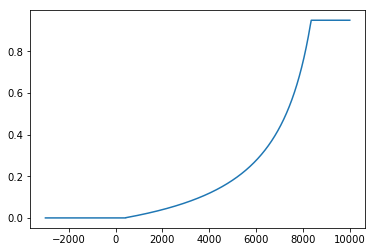

In [11]:
plt.plot(df_fPAR.NDVI,df_fPAR.fpar)

## Both APAR and NDVI

In [218]:
olap_thresh = 0.2
for p in df_raw.reset_index().past_name_.unique():
    print(p)
    df_temp2 = df_raw.reset_index()[df_raw.reset_index().past_name_== p].copy()
    df_temp2.dropna(axis=1,how='all',inplace=True)
    df_temp2 = df_temp2.reset_index()
    df_temp2['m_date'] = pd.to_datetime(df_temp2.yr*1000+df_temp2.doy,format='%Y%j')
    df_temp2.sort_values(by='m_date',inplace=True)
    df_temp2.set_index('m_date',inplace=True)
    g_columns=[]
    for x in df_temp2.columns.get_level_values(0).unique():
        if df_temp2[x].size > 0:
            g_columns.append(x)
#     df_temp2=df_temp2[g_columns].copy()
    
    
    df_interp1 = pd.DataFrame()
    df_interp1 = df_temp2.resample('D').interpolate()
    
    if np.nanmax(df_interp1.swaplevel(axis=1).pix_overlap.values.flatten())>.2:

        # Join PAR data #

        df_interp1 = df_interp1.merge(df_PAR[['CPER']],left_index=True,right_index=True,how='outer')
        #     #Rename ndvi to apar
        #     df_interp1 = df_interp1.rename(columns=rename_ndvi_apar)

        #convert ndvi to APAR
        for x in df_interp1.columns:
            if type(x[0])==int:
                df_interp1.loc[:,(x[0],'apar')] = f_fpar(df_interp1[x[0]].ndvi)*df_interp1.CPER.rad

        df_interp1['past_name_']=p


        #Calculate effective values
        tot_perc_pasture=0
        for x in g_columns:
            if type(x)==int:
                if np.nanmax(df_interp1[x].pix_overlap.unique())>olap_thresh:
                    df_interp1.loc[:,(x,'eff_ndvi')] = df_interp1[x].ndvi*df_interp1[x].perc_pasture
                    df_interp1.loc[:,(x,'eff_apar')] = df_interp1[x].apar*df_interp1[x].perc_pasture
                    tot_perc_pasture = tot_perc_pasture+np.nanmin(df_interp1[x].perc_pasture.unique())
                else:
                    df_interp1.loc[:,(x,'eff_ndvi')] = 0.
                    df_interp1.loc[:,(x,'eff_apar')] = 0.

        df_interp1 = df_interp1.reset_index().drop(columns=['filename','index']).set_index(['m_date','yr','doy','past_name_']).groupby(axis=1,level=['pix_id',1]).mean()

        df_past_ndvi_temp = pd.DataFrame(df_interp1.swaplevel(axis=1).eff_ndvi.sum(axis=1)[df_interp1.swaplevel(axis=1).eff_ndvi.count(axis=1)==pd.notnull(df_interp1.swaplevel(axis=1).eff_ndvi).sum(axis=1).max()],columns=['pasture_NDVI'])
        df_past_apar_temp = pd.DataFrame(df_interp1.swaplevel(axis=1).eff_apar.sum(axis=1)[df_interp1.swaplevel(axis=1).eff_apar.count(axis=1)==pd.notnull(df_interp1.swaplevel(axis=1).eff_apar).sum(axis=1).max()],columns=['pasture_APAR'])
        d = {0:df_past_ndvi_temp}
        d2 = {0:df_past_apar_temp}
        df_past_ndvi = pd.concat(d,axis=1)
        df_past_apar = pd.concat(d2,axis=1)

        df_past_ndvi[0,'pasture_NDVI'] = df_past_ndvi[0,'pasture_NDVI'] * (1. / tot_perc_pasture)
        df_past_apar[0,'pasture_APAR'] = df_past_apar[0,'pasture_APAR'] * (1. / tot_perc_pasture)



        df_f = df_interp1.merge(df_past_ndvi,how='left',left_index=True,right_index=True).merge(df_past_apar,how='left',left_index=True,right_index=True).sort_values(axis=0,by=['past_name_','yr','doy']).reset_index()#.sort_values(axis=1,by='pix_id').reset_index()
        pheno_info = pd.DataFrame(delayed_moving_ave(df_f.reset_index().set_index('m_date')[0,'pasture_NDVI'].reset_index())).T
        pheno_info.columns = pd.MultiIndex.from_tuples([(['Pasture','EOS']),(['Pasture','SOS'])])
        df_f2 = df_f.merge(pheno_info,how='left',left_on=df_f.m_date.dt.year,right_on=pheno_info.index)

        d_t = df_f2.reset_index().set_index('m_date')[[0,'Pasture']]
        d_t.columns = d_t.columns.droplevel()
        df_int = int_ndvi(d_t,'ndvi',p).reset_index()
        df_int.columns = pd.MultiIndex.from_tuples([(['m_date','']),(['doy','']),(['Pasture','NDVI_I'])])

        d_t_apar = df_f2.reset_index().set_index('m_date')[[0,'Pasture']]
        d_t_apar.columns = d_t_apar.columns.droplevel()
        df_int_apar = int_ndvi(d_t_apar[d_t_apar.index.year>2003],'apar',p).reset_index()
        df_int_apar.columns = pd.MultiIndex.from_tuples([(['m_date','']),(['doy','']),(['Pasture','APAR_I'])])

        df_f3 = df_f2.merge(df_int,how='left',left_on='m_date',right_on='m_date').merge(df_int_apar,how='left',left_on='m_date',right_on='m_date')
        df_f3.loc[:,(0,'pasture_NDVI')]=df_f3[0].pasture_NDVI/10000.

        df_f3.to_excel(p+'_MODIS_Pasture_Interpolated_NDVI_APAR_V4.xlsx')
        del(df_interp1)
        del(df_temp2)
        del(df_f)
        del(pheno_info)
        del(df_f2)
        del(df_f3)
        del(df_int)
        gc.collect()

# df_interp['m_date'] = pd.to_datetime(df_interp.yr*1000+df_interp.doy,format='%Y%j')
# df_interp = df_interp.set_index('m_date')
# #df_interp.resample('D').interpolate()
# #df_interp.columns = df_interp.columns.map('{0[0]}|{0[1]}'.format) 
# #df_interp[df_interp.index == '2014-01-02']


1W


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

1E


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

6EW


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

Pvt-6EE


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


5W


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


5E


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


Slayton


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

11NW


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

Pvt-12NE


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

12NW


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

12NWcorner
7NW


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

7SE


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

8NW


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


8E


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


11NS


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

10S


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

10SNE


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


Pvt-8SW


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

12C


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

HQ


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

8SE


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

Pvt-14


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

17N


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

15NWS


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

13W


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

18S


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

18N


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

17S


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

15E


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

13E


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

15SW


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

21N


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

22W


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

23W


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


22E


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

23E


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

19N


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

20NW


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

24 Grazing
24W


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

24E


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without

19S


/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/opt/conda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


PermissionError: [Errno 13] Permission denied

<Figure size 432x288 with 0 Axes>

In [196]:
np.nanmax(df_interp1.swaplevel(axis=1).pix_overlap.values.flatten())

1.0

In [190]:
df_interp1.swaplevel(axis=1).pix_overlap.values.flatten().max()>.2

True

In [29]:
df_test = df_interp1.merge(df_past_ndvi,how='left',left_index=True,right_index=True).sort_values(axis=0,by=['past_name_','yr','doy']).sort_values(axis=1,by='pix_id')

In [20]:
df_f2 = df_interp1.merge(df_past_ndvi,how='left',left_index=True,right_index=True).sort_values(axis=0,by=['past_name_','yr','doy']).sort_values(axis=1,by='pix_id').reset_index()
pheno_info = pd.DataFrame(delayed_moving_ave(df_f2.reset_index().set_index('m_date')[0,'pasture_NDVI'].reset_index())).T
pheno_info.columns = pd.MultiIndex.from_tuples([(['Pasture','EOS']),(['Pasture','SOS'])])
df_f3 = df_f2.merge(pheno_info,how='left',left_on=df_f2.m_date.dt.year,right_on=pheno_info.index)

d_t = df_f3.reset_index().set_index('m_date')[[0,'Pasture']]
d_t.columns = d_t.columns.droplevel()
df_int = int_ndvi(d_t).reset_index()
df_int.columns = pd.MultiIndex.from_tuples([(['m_date','']),(['doy','']),(['Pasture','NDVI_I'])])
df_f4 = df_f3.merge(df_int,how='left',left_on='m_date',right_on='m_date')

/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Redoing SOS for year 2001
Redoing SOS for year 2005
Redoing SOS for year 2006
Redoing EOS for year 2007
Redoing EOS for year 2008
Redoing SOS for year 2011
Redoing SOS for year 2012
Redoing EOS for year 2012
Redoing SOS for year 2013
Redoing EOS for year 2016
Redoing EOS for year 2017
Redoing SOS for year 2018
Redoing EOS for year 2018
[2001]
[2002]
[2004 2005]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [46]:
d_t[d_t.index.year==2003].EOS.unique()

array(['2004-01-03T00:00:00.000000000'], dtype='datetime64[ns]')

In [59]:
d_t[(d_t.index>=pd.to_datetime(2003*1000+1,format='%Y%j'))&(d_t.index<=d_t[d_t.index.year==2003].EOS.unique()[0])].EOS

m_date
2003-01-01   2004-01-03
2003-01-02   2004-01-03
2003-01-03   2004-01-03
2003-01-04   2004-01-03
2003-01-05   2004-01-03
2003-01-06   2004-01-03
2003-01-07   2004-01-03
2003-01-08   2004-01-03
2003-01-09   2004-01-03
2003-01-10   2004-01-03
2003-01-11   2004-01-03
2003-01-12   2004-01-03
2003-01-13   2004-01-03
2003-01-14   2004-01-03
2003-01-15   2004-01-03
2003-01-16   2004-01-03
2003-01-17   2004-01-03
2003-01-18   2004-01-03
2003-01-19   2004-01-03
2003-01-20   2004-01-03
2003-01-21   2004-01-03
2003-01-22   2004-01-03
2003-01-23   2004-01-03
2003-01-24   2004-01-03
2003-01-25   2004-01-03
2003-01-26   2004-01-03
2003-01-27   2004-01-03
2003-01-28   2004-01-03
2003-01-29   2004-01-03
2003-01-30   2004-01-03
                ...    
2003-12-05   2004-01-03
2003-12-06   2004-01-03
2003-12-07   2004-01-03
2003-12-08   2004-01-03
2003-12-09   2004-01-03
2003-12-10   2004-01-03
2003-12-11   2004-01-03
2003-12-12   2004-01-03
2003-12-13   2004-01-03
2003-12-14   2004-01-03
2003-12-1

In [48]:
d_t.index

DatetimeIndex(['2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09',
               '2001-01-10', '2001-01-11', '2001-01-12', '2001-01-13',
               '2001-01-14', '2001-01-15',
               ...
               '2018-11-11', '2018-11-12', '2018-11-13', '2018-11-14',
               '2018-11-15', '2018-11-16', '2018-11-17', '2018-11-18',
               '2018-11-19', '2018-11-20'],
              dtype='datetime64[ns]', name='m_date', length=6528, freq=None)

In [2254]:
len(df_f2)

6490

In [2228]:
#a = pd.DataFrame({'x':[1,2,3,4,5],'y':[1,2,3,4,5]}).set_index('x')
#b = pd.DataFrame({'x':[4,5,6,7,8],'y':[1,2,3,4,5]}).set_index('x')
#a.add(b,fill_value=0).add(b,fill_value=0)


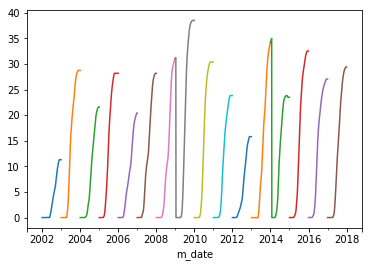

In [2237]:
for yr in k.reset_index().m_date.dt.year.unique()[1:-1]:
    k.reset_index()[k.reset_index().m_date.dt.year==yr].set_index('m_date').ndvi_i.plot()

In [576]:
# plt.figure(figsize=(36,8))
# #plt.plot(df_test.reset_index().set_index('m_date')[0,'pasture_NDVI'],'b.',alpha=.7)
# for k in s.keys():
#     if type(k) == int:
#         #d_start = pd.to_datetime(k*1000+s[k]['sos'],format='%Y%j')
#         d_start = s[k]['sos']
#         plt.plot([d_start,d_start],[10,3000],'r')
#         if pd.notnull(s[k]['eos']):
#             #d_end = pd.to_datetime(k*1000+s[k]['eos'],format='%Y%j')
#             d_end = s[k]['eos']
#             #plt.plot(pd.to_datetime([k,k],format='%Y'),[0,6000],'r--')
#             plt.plot([d_end,d_end],[10,3000],'k--')
#             plt.plot(pd.to_datetime([k,k+1],format='%Y'),[s[k]['thresh_l'],s[k]['thresh_l']])
#             plt.plot(pd.to_datetime([k,k+1],format='%Y'),[s[k]['thresh_h'],s[k]['thresh_h']])
#     if k =='all':
#         #plt.plot(s[k]['eos_ts'],'r--')
#         #plt.plot(s[k]['sos_ts'],'r--')
#         plt.plot(s[k]['sm_ts'],'b-')
#         #plt.plot(pd.to_datetime([2000,2018],format='%Y'),[s[k]['thresh'],s[k]['thresh']])


/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


2001
2001-11-12 00:00:00
Redoing SOS for year 2001
2002
2002-12-07 00:00:00
Redoing SOS for year 2002
2003
2003-11-25 00:00:00
Redoing SOS for year 2003
Redoing EOS for year 2003
2004
2004-12-07 00:00:00
Redoing SOS for year 2004
Redoing EOS for year 2004
2005
2005-11-21 00:00:00
Redoing SOS for year 2005
2006
2007-01-19 00:00:00
Redoing SOS for year 2006
2007
2007-12-21 00:00:00
Redoing EOS for year 2007
2008
2008-12-27 00:00:00
Redoing SOS for year 2008
Redoing EOS for year 2008
2009
2009-11-22 00:00:00
Redoing SOS for year 2009
Redoing EOS for year 2009
2010
2010-11-05 00:00:00
Redoing SOS for year 2010
Redoing EOS for year 2010
2011
2011-11-18 00:00:00
Redoing SOS for year 2011
Redoing EOS for year 2011
2012
2012-11-23 00:00:00
Redoing SOS for year 2012
Redoing EOS for year 2012
2013
2013-12-27 00:00:00
Redoing SOS for year 2013
2014-02-24 00:00:00
2013-12-27 00:00:00
Redoing EOS for year 2013
2014
2014-11-29 00:00:00
Redoing SOS for year 2014
Redoing EOS for year 2014
2015
2016-02

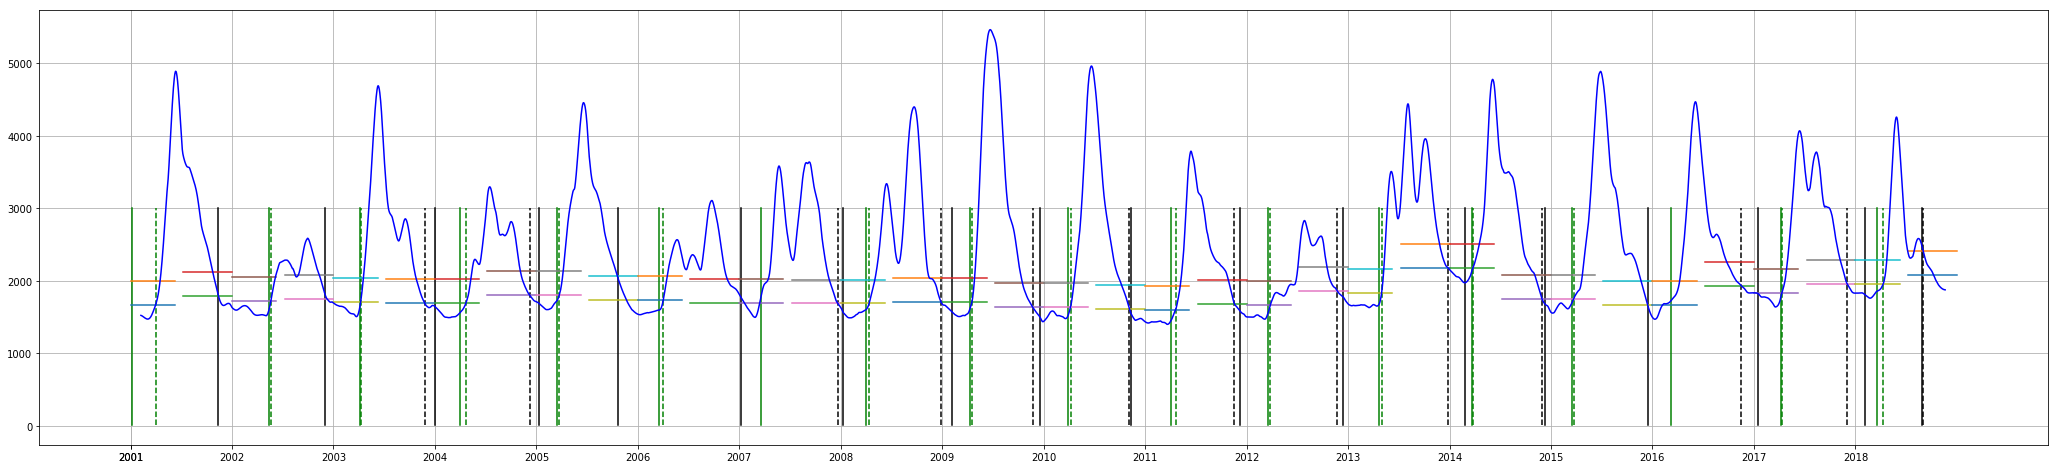

In [79]:
s = delayed_moving_ave(df_test.reset_index().set_index('m_date')[0,'pasture_NDVI'].reset_index(),False)

plt.figure(figsize=(36,8))
#plt.plot(df_test.reset_index().set_index('m_date')[0,'pasture_NDVI'],'b.',alpha=.7)
for k in s.keys():
    if type(k) == int:
        #d_start = pd.to_datetime(k*1000+s[k]['sos'],format='%Y%j')
        d_start = s[k]['sos']
        #plt.plot([d_start,d_start],[10,3000],'r')
        if pd.notnull(s[k]['eos'][0]):
            #d_end = pd.to_datetime(k*1000+s[k]['eos'],format='%Y%j')
            d_end = s[k]['eos']
            #plt.plot(pd.to_datetime([k,k],format='%Y'),[0,6000],'r--')
            if pd.notnull(d_end[0]):
                plt.plot([d_end[0],d_end[0]],[10,3000],'k-')
            if pd.notnull(d_end[1]):
                plt.plot([d_end[1],d_end[1]],[10,3000],'k--')
            if pd.notnull(d_start[0]):
                plt.plot([d_start[0],d_start[0]],[10,3000],'g-')
            if pd.notnull(d_start[1]):
                plt.plot([d_start[1],d_start[1]],[10,3000],'g--')
            plt.plot(pd.to_datetime([k*1000+1,k*1000+160],format='%Y%j'),[s[k]['thresh_l'],s[k]['thresh_l']])
            plt.plot(pd.to_datetime([k*1000+1,k*1000+160],format='%Y%j'),[s[k]['thresh_h'],s[k]['thresh_h']])
            plt.plot(pd.to_datetime([k*1000+190,(k+1)*1000+1],format='%Y%j'),[s[k]['thresh_l_inv'],s[k]['thresh_l_inv']])
            plt.plot(pd.to_datetime([k*1000+190,(k+1)*1000+1],format='%Y%j'),[s[k]['thresh_h_inv'],s[k]['thresh_h_inv']])
    if k =='all':
        #plt.plot(s[k]['eos_ts'],'r--')
        #plt.plot(s[k]['sos_ts'],'r--')
        plt.plot(s[k]['sm_ts'],'b-')
        #plt.plot(pd.to_datetime([2000,2018],format='%Y'),[s[k]['thresh'],s[k]['thresh']])
plt.xticks(pd.to_datetime(np.linspace(2001,2018,19).astype(int),format='%Y'))
plt.grid()
#plt.xlim('20130101','20140601')
#plt.plot([pd.to_datetime(2011,format='%Y'),pd.to_datetime(2011,format='%Y')],[1481,1481],'m--')
#plt.plot([pd.to_datetime(20110403,format='%Y%m%d'),pd.to_datetime(20110403,format='%Y%m%d')],[0,5000],'r--')
#plt.plot([pd.to_datetime(20110322,format='%Y%m%d'),pd.to_datetime(20110322,format='%Y%m%d')],[0,5000],'m--')

In [76]:
s[2013]

{'sos': [Timestamp('2013-04-21 00:00:00'), Timestamp('2013-05-02 00:00:00')],
 'eos': [Timestamp('2014-02-24 00:00:00'), nan],
 'thresh_l': 1828.8876844723898,
 'thresh_h': 2159.9494513925883,
 'thresh_l_inv': 2172.552562524188,
 'thresh_h_inv': 2503.614329444387}